# Twitch network analysis

The Twitch social network composes of users. A small percent of those users broadcast their gameplay or activities through live streams. In the graph model, users who do live streams are tagged with a secondary label Stream. Additional information about which teams they belong to, which games they play on stream, and in which language they present their content is present. You also know how many followers they had at the moment of scraping, the all-time historical view count, and when they created their user account. The most relevant information for network analysis is knowing which users engaged in the streamer’s chat. You can distinguish if the user who chatted in the stream was a regular user (CHATTER relationship), a moderator of the stream (MODERATOR relationship), or a VIP of the stream.

The network information was scraped between the 7th and the 10th of May 2021.

In [1]:
# Import Libraries
%matplotlib inline
from neo4j import GraphDatabase
import pandas as pd
import seaborn as sns
from matplotlib import pyplot
# Visual
sns.set(font_scale = 1.5)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', 1000) # Enables Pandas to display long strings properly

import warnings 
warnings.filterwarnings('ignore')

In [2]:
# Connect to Neo4j
driver = GraphDatabase.driver('bolt://localhost:7687', auth=('neo4j', 'letmein'))

def read_query(query):
    with driver.session() as session:
        result = session.run(query)
        return pd.DataFrame([r.values() for r in result], columns=result.keys())

# Exploratory graph analysis
Before diving into graph algorithms, I will want to be acquainted with the graph first.
An exploratory graph analysis be done by executing a couple of Cypher queries to learn more about the network. All bar charts in this notebook are created with the help of the Seaborn library. To begin, we will retrieve the top ten streamers by all-time historical view count.

In [3]:
# Reading database on its labels and properties
read_query("""
CALL apoc.meta.stats()
YIELD labels;
""")

,labels
0,"{'Game': 594, 'User': 4678779, 'Language': 29, 'Stream': 4540, 'Team': 1468}"


In this database, almost all nodes are users. There are 4678779 users and only 4540 of them are streamers. These streamers have played 594 games and broadcasted in 29 different languages. Data was scraped between the 7th and the 10th of May 2021.

In [ ]:
read_query("""
CALL apoc.meta.graphSample()
""")

![title](img/data_schema.png)

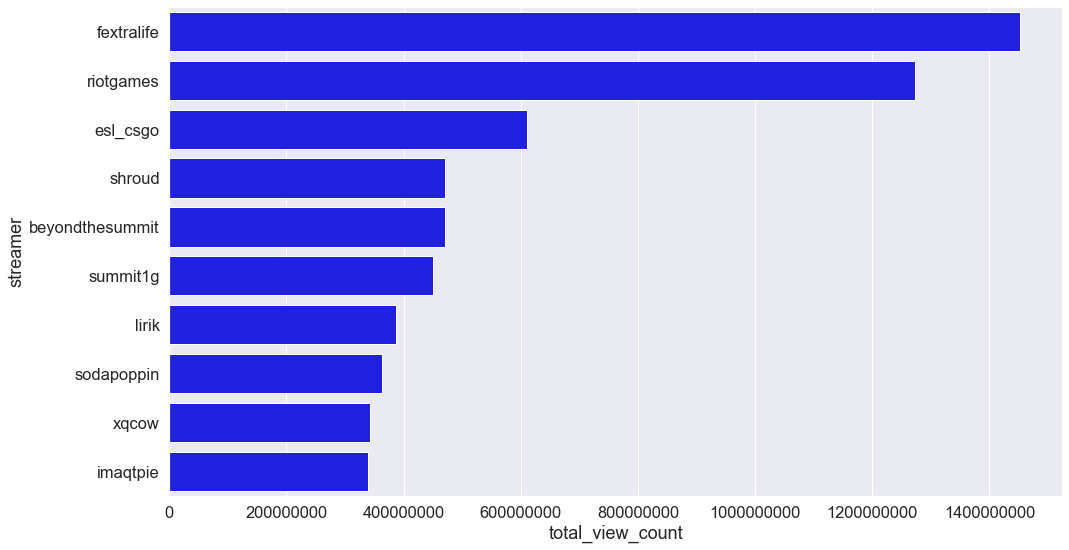

In [14]:
data = read_query("""
MATCH (u:Stream)
WHERE exists(u.total_view_count)
RETURN u.name as streamer,
       u.total_view_count as total_view_count
ORDER BY total_view_count DESC
LIMIT 10;
""")

fig, ax = pyplot.subplots(figsize=(16,9))
ax = sns.barplot(y="streamer", x="total_view_count", data=data, color="blue")
ax.ticklabel_format(style='plain', axis='x');
#ax.set_xticklabels(ax.get_xticklabels(), rotation=30);

The above bar plot shows Twitch streamers who have live-streamed between the 7th and the 10th of May. There might be other streamers that have higher all-time view counts. The top three all-time view count streamers in this plot seems to be from an organisations or team, whereas the other 7 streamers down the row are individuals. Since the top three streamers do seem to be from an organisation or team, the subsequent queries is to find out if there are variations of the same name.

In [16]:
# finding out variations for node name
read_query("""
MATCH (a:Stream{name: "fextralife"})
MATCH (b:Stream) where b.name <> a.name

WITH a, b, apoc.text.clean(a.name) AS norm1, apoc.text.clean(b.name) AS norm2
WITH toInteger(apoc.text.jaroWinklerDistance(norm1, norm2) * 100) AS similarity, a, b
WITH a, b,similarity where similarity >= 80 
RETURN a.name AS aname, b.name AS bname, similarity
""")

,aname,bname,similarity


Upon further research, the streamer "fextralife" are a team of different people, taking turns to stream different genres of games.

In [17]:
# finding out variations for node name
read_query("""
MATCH (a:Stream{name: "riotgames"})
MATCH (b:Stream) where b.name <> a.name

WITH a, b, apoc.text.clean(a.name) AS norm1, apoc.text.clean(b.name) AS norm2
WITH toInteger(apoc.text.jaroWinklerDistance(norm1, norm2) * 100) AS similarity, a, b
WITH a, b,similarity where similarity >= 80 
RETURN a.name AS aname, b.name AS bname, similarity
""").to_dataframe()

,aname,bname,similarity
0,riotgames,f1ninogames,80
1,riotgames,riotgamesjp,96
2,riotgames,riotgamesturkish,91
3,riotgames,riotgamesru,96


The results in the above table shows that there are 4 results. Only "f1ninogames" will not be considered to have any relations to "riotgames" because of the naming convention, as the other results suggest that they are different channels from the same company to cater for language differences. 

In [ ]:
read_query("""
MATCH (u:Stream{name:'riotgames'})-[r]->(b)
RETURN u,r,b
""")

![title](img/riotgames.png)

With the above qurey, the node 'riotgames' has 3 types of relationships. 
1) 2 of which are under 'HAS_TEAM' to Riot games and League of Legends Championship Series. 
2) 'HAS_LANGUAGE' is connected to English
3) 'PLAYS' is towards League of Legends

Lets see if the other nodes of similar names under Riot Games would produce the same results.

In [ ]:
read_query("""
WITH ['riotgames','riotgamesjp','riotgamesturkish','riotgamesru'] AS riot
MATCH (u:Stream)-[r]->(b)
WHERE u.name IN riot
RETURN u,r,b
""")

![title](img/riotgames2.png)

As predicited, the other streamers that has 'riotgames' naming convention leads to their unique language relationships. All nodes under riotgames also has relationship towards League of Legends. However, there are some inconsistencies on "HAS_TEAM" for the nodes riotgames nodes. Riot Games also owns other games like Valorant, but League of Legends only shows up. This is because from the 7th to the 10th of May, a tournement was happening. The following code shows the total viewer count from all 4 users.

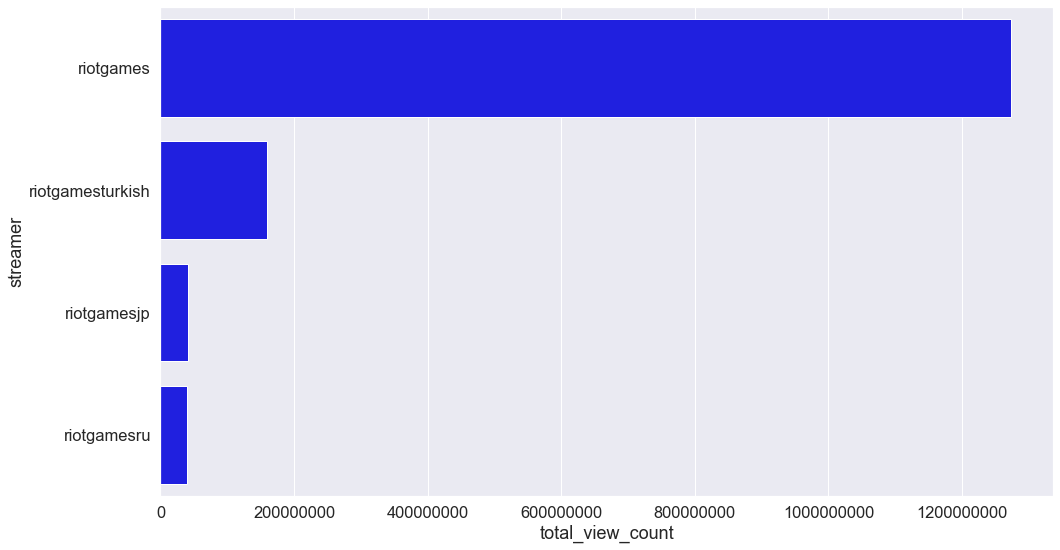

In [28]:
data = read_query("""
WITH ['riotgames','riotgamesjp','riotgamesturkish','riotgamesru'] AS riot
MATCH (a:Stream)
WHERE a.name IN riot
RETURN a.name as streamer,
       a.total_view_count as total_view_count
ORDER BY total_view_count DESC;
""")

fig, ax = pyplot.subplots(figsize=(16,9))
ax = sns.barplot(y="streamer", x="total_view_count", data=data, color="blue")
ax.ticklabel_format(style='plain', axis='x');

Now, lets take a look at ESL, another organization that manages tournements for CSGO, Counter Strike Global Offensive. A similar approach will be done for ESL, where I find the node relationships, the variation of its name, and compare those node relationships to the main node.

In [ ]:
read_query("""
MATCH (u:Stream{name:'esl_csgo'})-[r]->(b)
RETURN u,r,b
""")

![title](img/esl_csgo.png)

esl_csgo has many more team relationships, but only plays 1 game and has only 1 language. At that point of time from 7 to 10 May, ESL also had an tournement, lets see if there are other channels that have similar relationships.

In [12]:
# finding out variations for node name
read_query("""
MATCH (a:Stream{name: "esl_csgo"})
MATCH (b:Stream) WHERE b.name <> a.name

WITH a, b, apoc.text.clean(a.name) AS norm1, apoc.text.clean(b.name) AS norm2
WITH toInteger(apoc.text.jaroWinklerDistance(norm1, norm2) * 100) AS similarity, a, b
WITH a, b,similarity WHERE similarity >= 80 
RETURN a.name AS aname, b.name AS bname, similarity
""")

,aname,bname,similarity
0,esl_csgo,esl_csgo_fr,95
1,esl_csgo,esl_wc3,82
2,esl_csgo,esl_csgo_pl,95
3,esl_csgo,tes_csgo,90
4,esl_csgo,esl_pov1,80
5,esl_csgo,esl_csgob_pl,94
6,esl_csgo,esl_sc2,84
7,esl_csgo,mslcsgo,90
8,esl_csgo,esl_pov2,80
9,esl_csgo,esl_pov6,80


For this query, more results are shown. Majority of the result either shows that they are catering to a different language. However, mslcsgo is not part of any organisation, and its an individual that streams, thus will be removed from comparisions. esl_wc3 and esl_sc2 have the main organisation's acronym, however, at the end of the user name, it is completely different as compared to "esl_csgo". These 2 users are catering to a different game in this case, Warcraft 3 and Starcraft 2 respectively. Upon further researching, esbcsgo1 is on its own entity, where the streams from this user are of different ruleset and different tourney. 

In [ ]:
read_query("""
WITH ['esl_csgo_fr', 'esl_csgo_pl','esl_csgo','esl_pov1','esl_csgob_pl','esl_pov2','esl_pov6'] AS esl
MATCH (u:Stream)-[r]->(b)
WHERE u.name IN riot
RETURN u,r,b
""")

![title](img/esl_csgo2.png)

Same characteristics as what Riot Games had, where nodes are inconsistent in relationships to teams, however, the common theme here is that they are connected to the same game, and its own respective language. It is interesting to see that there are 2 nodes that are meant for english, yet those users that streams for the english audience are not connected to both at the same time. Now, lets take a look at the total view count.


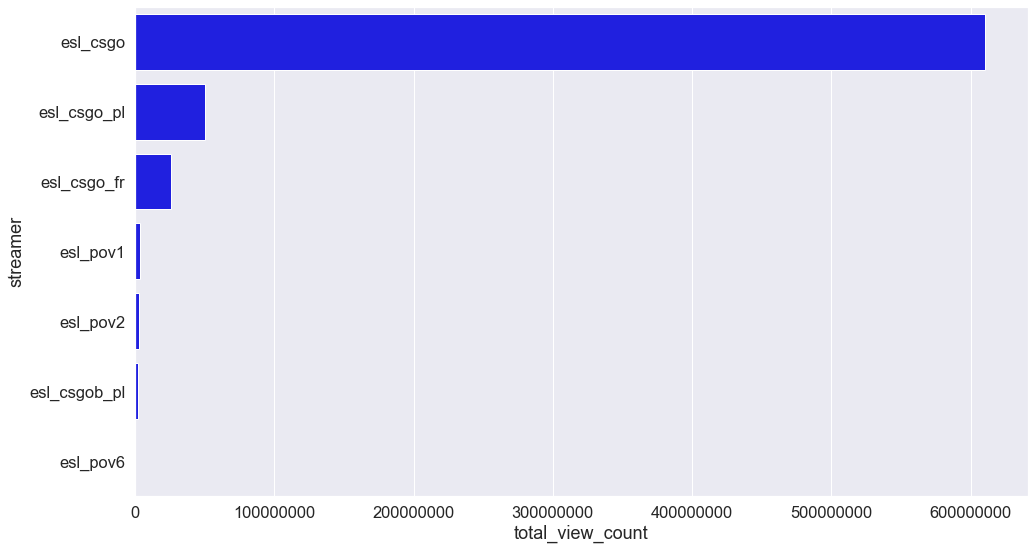

In [29]:
data = read_query("""
WITH ['esl_csgo_fr', 'esl_csgo_pl','esl_csgo','esl_pov1','esl_csgob_pl','esl_pov2','esl_pov6'] AS esl
MATCH (a:Stream)
WHERE a.name IN esl
RETURN a.name as streamer,
       a.total_view_count as total_view_count
ORDER BY total_view_count DESC;
""")

fig, ax = pyplot.subplots(figsize=(16,9))
ax = sns.barplot(y="streamer", x="total_view_count", data=data, color="blue")
ax.ticklabel_format(style='plain', axis='x');

Similar characteristics as compared to Riot Games, where the main user has the most amount of viewer count. I would like to point out that esl_pov1, esl_pov2 and esl_pov6 are probably slightly different from the main stream, where player's point of view are streamed from these users, and only select few individuals would be interested in them. I will now move onto follower count.

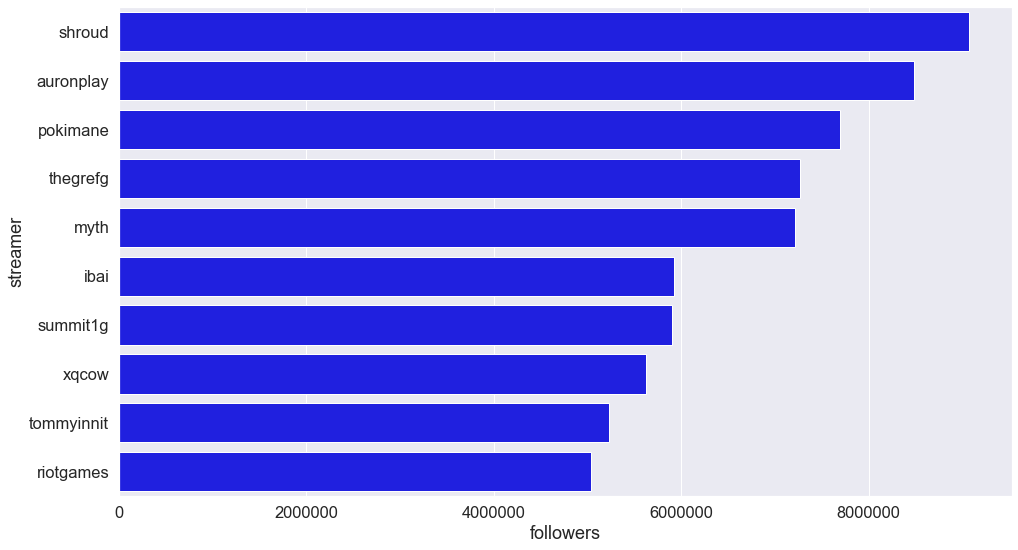

In [5]:
data = read_query("""
MATCH (u:Stream)
WHERE exists(u.followers)
RETURN u.name as streamer,
       u.followers as followers
ORDER BY followers DESC
LIMIT 10;
""")

fig, ax = pyplot.subplots(figsize=(16,9))
ax = sns.barplot(x="followers", y="streamer", data=data, color="blue")
ax.ticklabel_format(style='plain', axis='x');
#ax.set_yticklabels(ax.get_yticklabels(), rotation=30)

The results shown above are a different group of streamers, as compared to the viewer count query. Except for Shroud, he is fourth in the all-time view count category and second in the highest follower count. Riot Games made into this list, while esl_csgo did not. Even though both of these channels have high viewer count during these days, they do not have high followers. The reason for this is because users are only interested to tune in when there is an on going tournement. On Twitch, having to "follow" a streamer will give you notifications when they are live. Since ESL and Riot Games are bigger organisations, there would be other source of annoucements on other platforms. Now, we will move into aggregating the count of streams by their user creation date.

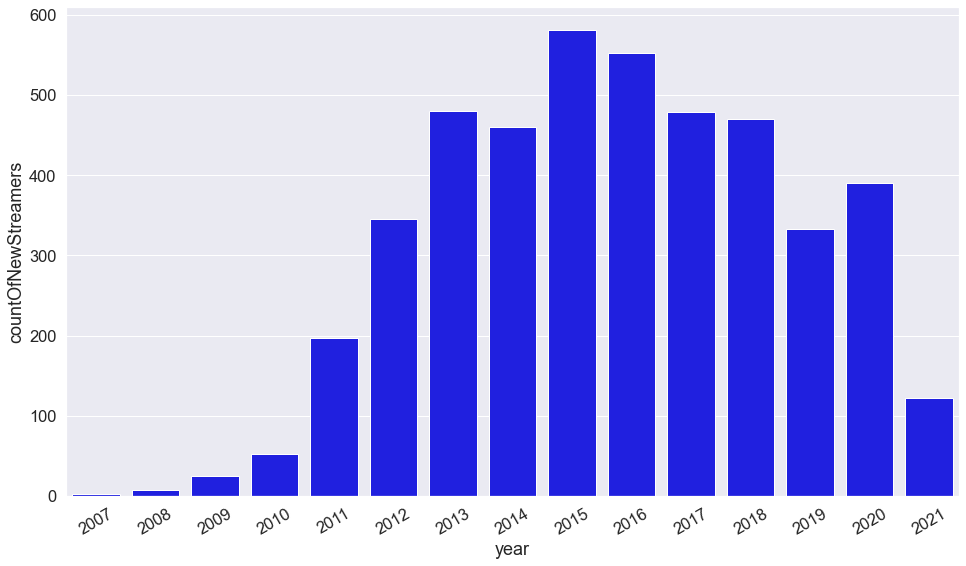

In [6]:
data = read_query("""
MATCH (u:Stream)
WHERE exists(u.createdAt)
RETURN u.createdAt.year as year,
       count(*) as countOfNewStreamers
ORDER BY year;
""")

fig, ax = pyplot.subplots(figsize=(16,9))
ax = sns.barplot(x="year", y="countOfNewStreamers", data=data, color="blue")
ax.set_xticklabels(ax.get_xticklabels(), rotation=30);

The aggregation done here is by the date of when the user account was created and not when they first started streaming. Unfortunately, the date of the user's first stream is not available in this database. Judging by the results, at least some of the streamers have already a ten-year career on Twitch. We can move away from the streamers and investigate which games are played by most streamers. Note that a streamer can play more than a single game, so they might be counted under multiple games. Our data was collected between Friday and Sunday, so a streamer might prefer to play Valorant on Friday and Poker on Sunday.

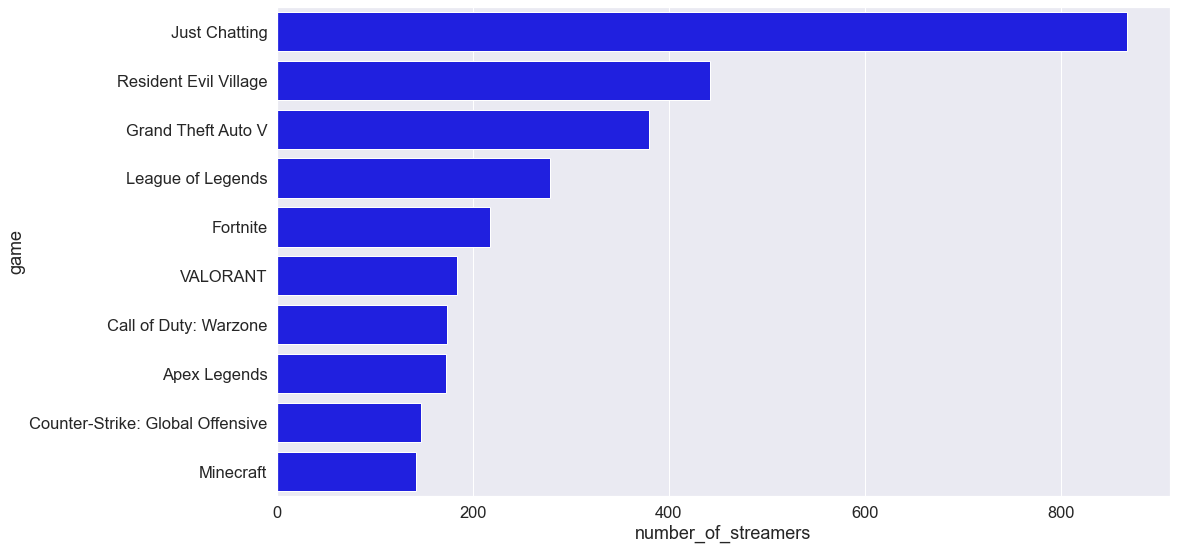

In [30]:
data = read_query("""
MATCH (g:Game)
RETURN g.name as game,
       size((g)<--()) as number_of_streamers
ORDER BY number_of_streamers DESC
LIMIT 10
""")

fig, ax = pyplot.subplots(figsize=(16,9))
ax = sns.barplot(y="game", x="number_of_streamers", data=data, color="blue");
#ax.set_xticklabels(ax.get_xticklabels(), rotation=45);

The most popular is the Just Chatting category. The cause of the Just Chatting category popularity might be due to the reason that it is used for all streams that don't play a specific video game. This might include anything from cooking shows to "In real life" streams, where the streamer is walking around the world with a camera in hand. The reason why there is an high amount of streamers that are playing Resident Evil Village is because, that game was released on the 2nd May 2021. Since it is a new game, there is hype around the game and people will want to play it. Next up, we have Grand Theft Auto V. Even though it was released in the 2013, there was a short period of time where streamers collaborated together for content creation, where they hosted servers to have "role-play" in them. The subsequent games down the list are popular games that people play these days.


# User network analysis
You might remember that only around 6000 out of 10 million users in our graph are streamers. If we put that into perspective, only 0.06% of users are streamers. The other users in our database are users who have chatted on other streamers' broadcasts. So far, we have entirely ignored them in our exploratory graph analysis. That is, until now. Graph data science focuses on analyzing connections between entities in a network.
The time is right to put on our graph data science hats and examine relationships between users in the network. As a brief reminder of the graph structure, let's visualize a small subgraph of the user network.

In [11]:
read_query("""
MATCH (s:Stream)
WITH s LIMIT 1
CALL {
    WITH s
    MATCH p=(s)--(:Stream)
    RETURN p
    LIMIT 5

    UNION

    WITH s
    MATCH p=(s)--(:User)
    RETURN p
    LIMIT 5
}

RETURN p
""")

,p
0,(())
1,(())
2,(())
3,(())
4,(())
5,(())
6,(())
7,(())
8,(())
9,(())


As mentioned in the previous blog post, streamers behave like regular users. They can moderate other broadcasts, can engage in their chat, or earn VIP status. This was the reason that drove the graph model decision to represent streamers as regular users with a secondary label Stream. We don't want to have two nodes in the graph represent a single real-world entity.
To start, we will evaluate the node degree distribution. Node degree is simply the count of relationships each node has. Here, we are dealing with a directed network as the relationship direction holds semantic value. If Aimful is a moderator of the Itsbigchase stream, it doesn't automatically mean that then Itsbigchase is a moderator of the Aimful stream. When dealing with directed networks, you can split the node degree distribution into in-degree, where you count incoming relationships, and out-degree, where you are counting outgoing connections. First, we will examine the out-degree distribution.

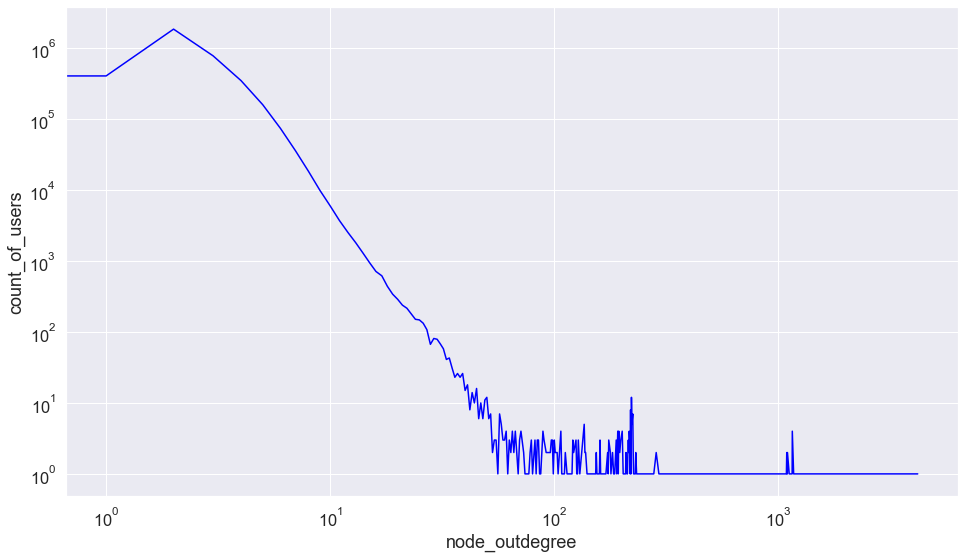

In [12]:
data = read_query("""
MATCH (u:User)
WITH u, size((u)-[:CHATTER|VIP|MODERATOR]->()) as node_outdegree
RETURN node_outdegree, count(*) as count_of_users
ORDER BY node_outdegree ASC
""")

fig, ax = pyplot.subplots(figsize=(16,9))
ax = sns.lineplot(x="node_outdegree", y="count_of_users", data=data, color="blue")
ax.set_yscale("log")
ax.set_xscale("log")

A log-log plot visualizes the out-degree distribution. Both axes have a logarithmic scale. Around six million out of a total of ten million users have exactly a single outgoing relationship, meaning they have only chatted in a single stream. The vast majority of users have less than ten outgoing connections. A couple of users have more than 100 outgoing links, but I would venture a guess that they are most likely bots. Some mathematicians might consider the out-degree following a Power-Law distribution. Now, let's look at the in-degree distribution. We already know that only streamers will have an in-degree higher than 0. Only the users who broadcast their streams can have users engage in their chat. Consequently, around 99.999% of users have an in-degree value of 0. You could almost treat this network as a bipartite graph, except that there are also relationships between streamers. We will visualize the in-degree distribution only for streamers.

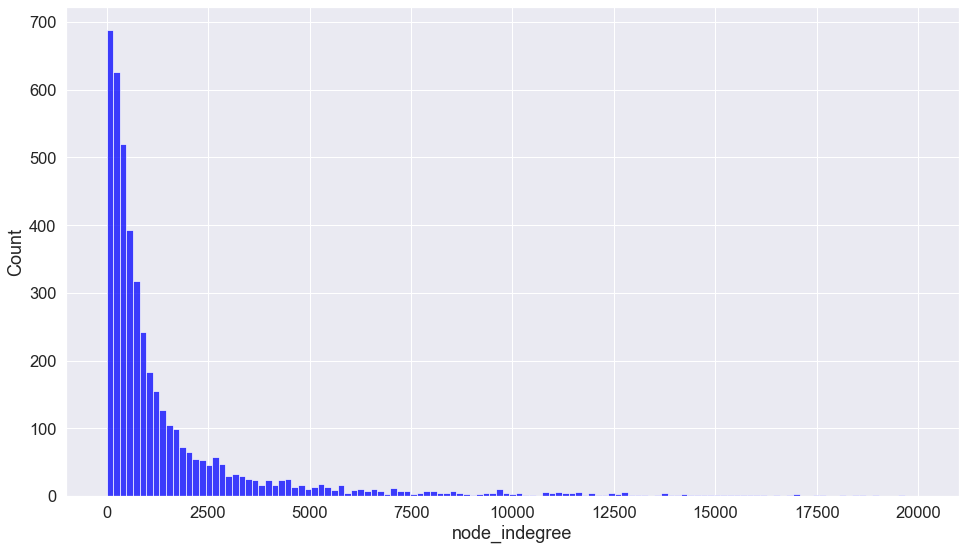

In [13]:
data = read_query("""MATCH (u:Stream)
RETURN u, size((u)<-[:CHATTER|VIP|MODERATOR]-()) as node_indegree
""")

fig, ax = pyplot.subplots(figsize=(16,9))
ax = sns.histplot(x="node_indegree",data=data, color="blue", binrange=[0,20000])



It is pretty interesting to observe that the in-degree distribution also follows the Power-law distribution. Most streamers have less than 1000 active chatters on the weekend, while some streamers have more than 15000 active chatters.

# Graph Data Science library

The GDS library executes graph algorithms on a specialized in-memory graph format to improve the performance and scale of graph algorithms. Using native or cypher projections, we can project the stored graph in our database to the in-memory graph format. Before we can execute any graph algorithms, we have to project a view of our stored graph to in-memory graph format. We can filter which parts of the graph we want to project. There is no need to add nodes and relationships that will not be used as an input to a graph algorithm. We will begin by projecting all User and Stream nodes and the possible relationships between them, which are CHATTER, MODERATOR, and VIP.


In [14]:
huh

NameError: name 'huh' is not defined

In [ ]:
data = read_query("""
CALL gds.graph.project('twitch',
  ['User', 'Stream'],
  ['CHATTER', 'VIP', 'MODERATOR'])
""")

## Weakly Connected Components
The Weakly connected components algorithm (WCC) is used to find disparate islands or components of nodes within a given network. A node can reach all the other nodes in the same component when you disregard the relationship direction. 
Use the following Cypher query to execute a Weakly-Connected Components algorithm on the Twitch network we have previously projected in memory. The stats method of the algorithm is used when we are interested in only high-level statistics of algorithm results.

In [ ]:
read_query("""
CALL gds.wcc.stats('twitch')
YIELD componentCount, componentDistribution
""")

,componentCount,componentDistribution
0,965095,"{'p99': 1, 'min': 1, 'max': 3713695, 'mean': 4.8480014920810905, 'p90': 1, 'p50': 1, 'p999': 1, 'p95': 1, 'p75': 1}"


Very interesting to see that the user network is composed of only a single connected component. For example, you could find an undirected path between a user who watches Japanese streams and another user who looks at Hungarian streams. It might be interesting to remove the bots from the graph and rerun the WCC algorithm. I have a hunch that the Nightbot and other bots help connect disparate parts of the network into a single connected component.
With the current in-memory graph projection, we can also filter at algorithm execution time nodes or relationships. In the next example, I have chosen to consider only Stream nodes and connections between them.

In [ ]:
read_query("""
CALL gds.wcc.stats('twitch', {nodeLabels:['Stream']})
YIELD componentCount, componentDistribution
""")

,componentCount,componentDistribution
0,2157,"{'p99': 3, 'min': 1, 'max': 2203, 'mean': 2.10477515067223, 'p90': 1, 'p50': 1, 'p999': 9, 'p95': 1, 'p75': 1}"


With this variation of the WCC algorithm, we are effectively looking at chat communication between streamers. Only Stream nodes are considered, and so, only relationships between Stream nodes are used as an input to the WCC algorithm. There are a total of 1902 separate components in the streamer network. The largest component contains around 65% of all stream nodes. And then, we are dealing with primarily single node components, where a streamer hasn't chatted in other streamers' broadcast on the specific weekend the data was scraped.

## Community detection
The last category of graph algorithms we will look at is the community detection category. Community detection or clustering algorithms are used to infer the community structure of a given network. Communities are vaguely defined as groups of nodes within a network that are more densely connected to one another than to other nodes. We could try to examine the community structure of the whole user network, but that does not make a pretty network visualization of results. First of all, we will release the existing project network from memory.

I like to sometimes watch either chess or poker streamers. Let's analyze the community structure of a subgraph that contains poker and chess streamers. To ease our further queries, we will first tag relevant nodes with an additional node label.

In [ ]:
read_query("""
MATCH (s:Stream)-[:PLAYS]->(g:Game)
WHERE g.name in ["Valorant","Counter-Strike: Global Offensive"]
SET s:ValCSGO
""")

""


There were a total of 63 streamers that broadcasted either chess or poker on their channel.
If you only plan to run a single graph algorithm, you can use the anonymous graph feature, where you project and execute a graph algorithm in one step. Here, we will use the Louvain Modularity algorithm to infer the community structure of this subgraph. We will also treat this network as undirected. I would say that if a streamer engages in another streamer's chat, they are probably friends, and usually, friendship relationships go both ways. This time we will store the results of the Louvain Modularity algorithm back to the stored graph, so we can use the community structure information in our visualizations.

In [ ]:
read_query("""
CALL gds.graph.project('CSGOVal','ValCSGO', {ALL: {orientation:'UNDIRECTED', type:'*'}})
""")

,nodeProjection,relationshipProjection,graphName,nodeCount,relationshipCount,projectMillis
0,"{'ValCSGO': {'label': 'ValCSGO', 'properties': {}}}","{'ALL': {'orientation': 'UNDIRECTED', 'aggregation': 'DEFAULT', 'type': '*', 'properties': {}}}",CSGOVal,147,144,1070


In [ ]:
read_query("""CALL gds.louvain.write('CSGOVal', {
    writeProperty:'louvain_CSGOVal'
})""")

,writeMillis,nodePropertiesWritten,modularity,modularities,ranLevels,communityCount,communityDistribution,postProcessingMillis,preProcessingMillis,computeMillis,configuration
0,23,147,0.674286,"[0.5582561728395061, 0.6742862654320988]",2,91,"{'p99': 11, 'min': 1, 'max': 15, 'mean': 1.6153846153846154, 'p90': 2, 'p50': 1, 'p999': 15, 'p95': 5, 'p75': 1}",1,0,98,"{'maxIterations': 10, 'writeConcurrency': 4, 'seedProperty': None, 'consecutiveIds': False, 'maxLevels': 10, 'relationshipWeightProperty': None, 'concurrency': 4, 'writeProperty': 'louvain_CSGOVal', 'includeIntermediateCommunities': False, 'nodeLabels': ['*'], 'sudo': False, 'relationshipTypes': ['*'], 'tolerance': 0.0001, 'username': None}"


And now, I want to show you one last cool thing you can do in Neo4j. Instead of looking at which streamers interact with each other, we can examine which streamers share their audience. We don't have all the viewers in our database, but we have the viewers that have chatted on streamers' broadcasts. First, we will tag users who have more than a single outgoing relationship. This will help us speed up the audience comparison process.

In [ ]:
read_query("""CALL apoc.periodic.iterate("
    MATCH (u:User)
    WHERE size((u)-->(:Stream)) > 1
    RETURN u",
    "SET u:Audiences",
    {batchSize:50000, parallel:true}
)""")

,batches,total,timeTaken,committedOperations,failedOperations,failedBatches,retries,errorMessages,batch,operations,wasTerminated,failedParams,updateStatistics
0,67,3304360,13,3304360,0,0,0,{},"{'total': 67, 'committed': 67, 'failed': 0, 'errors': {}}","{'total': 3304360, 'committed': 3304360, 'failed': 0, 'errors': {}}",False,{},"{'nodesDeleted': 0, 'labelsAdded': 3304360, 'relationshipsCreated': 0, 'nodesCreated': 0, 'propertiesSet': 0, 'relationshipsDeleted': 0, 'labelsRemoved': 0}"


We need to infer a new network that depicts which streamers share their audience before we can run a community detection algorithm. To start off, we must project an in-memory graph.

In [ ]:
read_query("""
CALL gds.graph.project('shared-audience',
  ['ValCSGO', 'Audiences'],
  {CHATTERS: {type:'*', orientation:'REVERSE'}})
""")

,nodeProjection,relationshipProjection,graphName,nodeCount,relationshipCount,projectMillis
0,"{'ValCSGO': {'label': 'ValCSGO', 'properties': {}}, 'Audiences': {'label': 'Audiences', 'properties': {}}}","{'CHATTERS': {'orientation': 'REVERSE', 'aggregation': 'DEFAULT', 'type': '*', 'properties': {}}}",shared-audience,3304468,3223833,1360


Next, we will use the Node Similarity algorithm to infer the shared audience network. The Node Similarity algorithm uses the Jaccard similarity coefficient to compare how similar a pair of nodes are. We will assume that if two streamers share at least 5% of the audience. The mutate mode of the algorithms stores the results back to the in-memory projected graph. This was we can use the results of one algorithm as an input to another graph algorithm.

In [ ]:
read_query("""
CALL gds.nodeSimilarity.mutate('shared-audience',
 {similarityCutoff:0.05, topK:15, mutateProperty:'score', mutateRelationshipType:'SHARED_AUDIENCE', similarityMetric: 'Jaccard'})
""")

,preProcessingMillis,computeMillis,mutateMillis,postProcessingMillis,nodesCompared,relationshipsWritten,similarityDistribution,configuration
0,0,2725,76,-1,1127,4768,"{'p1': 0.05023908615112305, 'max': 0.541187047958374, 'p5': 0.051418304443359375, 'p90': 0.16666674613952637, 'p50': 0.07377028465270996, 'p95': 0.2045457363128662, 'p10': 0.05328202247619629, 'p75': 0.11029410362243652, 'p99': 0.3066670894622803, 'p25': 0.059171438217163086, 'p100': 0.541187047958374, 'min': 0.04999995231628418, 'mean': 0.09463253702293306, 'stdDev': 0.054402874828873835}","{'topK': 15, 'similarityMetric': 'Jaccard', 'bottomK': 10, 'bottomN': 0, 'relationshipWeightProperty': None, 'mutateRelationshipType': 'SHARED_AUDIENCE', 'topN': 0, 'concurrency': 4, 'degreeCutoff': 1, 'similarityCutoff': 0.05, 'nodeLabels': ['*'], 'sudo': False, 'relationshipTypes': ['*'], 'mutateProperty': 'score', 'username': None}"


And finally, we can run the community detection algorithm Louvain on the shared audience network between poker and chess streamers.

In [ ]:
read_query("""
CALL gds.louvain.write('shared-audience', 
       { nodeLabels:['ValCSGO'],
         relationshipTypes:['SHARED_AUDIENCE'], 
         relationshipWeightProperty:'score',
         writeProperty:'louvain_shared_audience'})
""")

,writeMillis,nodePropertiesWritten,modularity,modularities,ranLevels,communityCount,communityDistribution,postProcessingMillis,preProcessingMillis,computeMillis,configuration
0,20,147,0.722714,[0.7227143223531893],1,67,"{'p99': 12, 'min': 1, 'max': 27, 'mean': 2.1940298507462686, 'p90': 4, 'p50': 1, 'p999': 27, 'p95': 5, 'p75': 2}",2,1,87,"{'maxIterations': 10, 'writeConcurrency': 4, 'seedProperty': None, 'consecutiveIds': False, 'maxLevels': 10, 'relationshipWeightProperty': 'score', 'concurrency': 4, 'writeProperty': 'louvain_shared_audience', 'includeIntermediateCommunities': False, 'nodeLabels': ['ValCSGO'], 'sudo': False, 'relationshipTypes': ['SHARED_AUDIENCE'], 'tolerance': 0.0001, 'username': None}"


In [ ]:
read_query("""
CALL gds.graph.drop("shared-audience")
""")

,graphName,database,memoryUsage,sizeInBytes,nodeCount,relationshipCount,configuration,density,creationTime,modificationTime,schema
0,shared-audience,neo4j,,-1,3304468,3228601,"{'relationshipProjection': {'CHATTERS': {'orientation': 'REVERSE', 'aggregation': 'DEFAULT', 'type': '*', 'properties': {}}}, 'nodeProjection': {'ValCSGO': {'label': 'ValCSGO', 'properties': {}}, 'Audiences': {'label': 'Audiences', 'properties': {}}}, 'relationshipProperties': [], 'creationTime': 2022-06-06T03:56:25.565245300+08:00, 'validateRelationships': False, 'readConcurrency': 4, 'sudo': False, 'nodeProperties': [], 'username': None}",2.956728e-07,2022-06-06T03:56:25.565245300+08:00,2022-06-06T03:56:32.746327600+08:00,"{'relationships': {'SHARED_AUDIENCE': {'score': 'Float (DefaultValue(NaN), TRANSIENT, Aggregation.NONE)'}, 'CHATTERS': {}}, 'nodes': {'ValCSGO': {}, 'Audiences': {}}}"


In [ ]:
read_query("""
CALL gds.graph.drop("CSGOVal")
""")

,graphName,database,memoryUsage,sizeInBytes,nodeCount,relationshipCount,configuration,density,creationTime,modificationTime,schema
0,CSGOVal,neo4j,,-1,147,144,"{'relationshipProjection': {'ALL': {'orientation': 'UNDIRECTED', 'aggregation': 'DEFAULT', 'type': '*', 'properties': {}}}, 'nodeProjection': {'ValCSGO': {'label': 'ValCSGO', 'properties': {}}}, 'relationshipProperties': [], 'creationTime': 2022-06-06T03:54:39.527965400+08:00, 'validateRelationships': False, 'readConcurrency': 4, 'sudo': False, 'nodeProperties': [], 'username': None}",0.00671,2022-06-06T03:54:39.527965400+08:00,2022-06-06T03:54:40.597836700+08:00,"{'relationships': {'ALL': {}}, 'nodes': {'ValCSGO': {}}}"


In [ ]:
"""MATCH p=(u:User)-[:PLAYS|:HAS_TEAM|:HAS_LANGUAGE]->(g:Game)
WHERE u.followers >= 200000 and u.total_view_count >=100000 
RETURN p
LIMIT 100
"""